In [2]:
%pip install medmnist
%pip install matplotlib
%pip install numpy
import medmnist

from medmnist import OrganAMNIST
trainDataset = OrganAMNIST(split="train", download=True,size=28)
valDataset = OrganAMNIST(split="val", download=True,size=28)
testDataset = OrganAMNIST(split="test", download=True,size=28)



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Træningsdata:
Billeder: (34561, 28, 28), Labels: (34561, 1)
Valideringsdata:
Billeder: (6491, 28, 28), Labels: (6491, 1)


plot nogle eksempler:
klasse: 0, klassenavn: bladder. Antal træning samples: 1956
klasse: 1, klassenavn: femur-left. Antal træning samples: 1390
klasse: 2, klassenavn: femur-right. Antal træning samples: 1357
klasse: 3, klassenavn: heart. Antal træning samples: 1474
klasse: 4, klassenavn: kidney-left. Antal træning samples: 3963
klasse: 5, klassenavn: kidney-right. Antal træning samples: 3817
klasse: 6, klassenavn: liver. Antal træning samples: 6164
klasse: 7, klassenavn: lung-left. Antal træning samples: 3919
klasse: 8, klassenavn: lung-right. Antal træning samples: 3929
klasse: 9, klassenavn: pancreas. Antal træning samples: 3031
klasse: 10, klassenavn: spleen. Antal træning samples: 3561


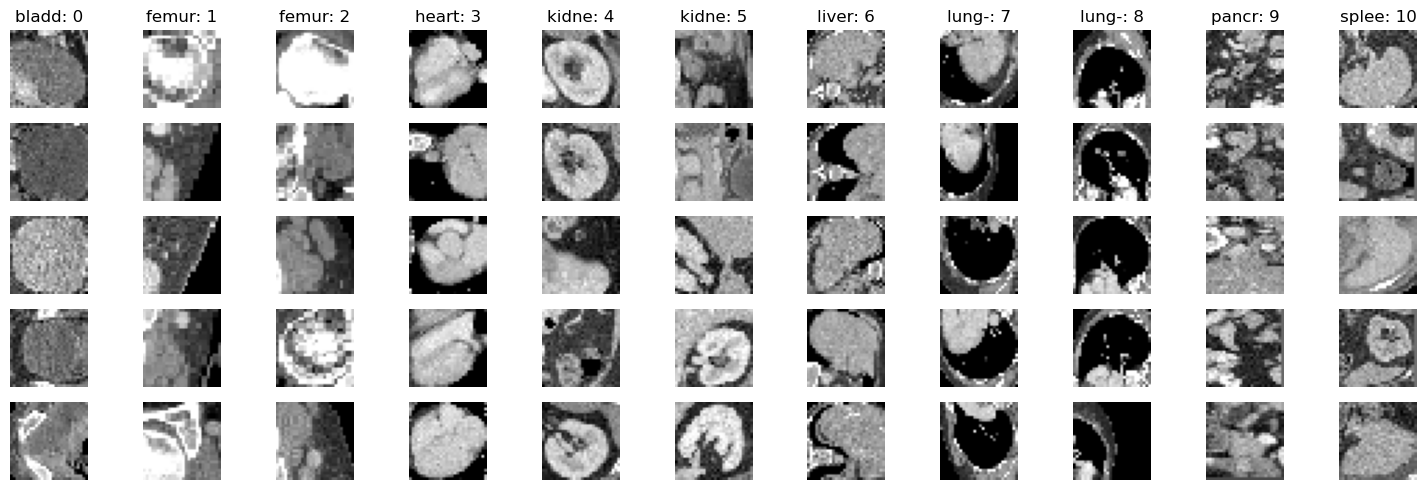

In [3]:

trainImages, trainLabels, trainInfo = trainDataset.__dict__['imgs'], trainDataset.__dict__['labels'], \
trainDataset.__dict__['info']['label']

print('Træningsdata:')
print(f'Billeder: {trainImages.shape}, Labels: {trainLabels.shape}')

valImages, valLabels = valDataset.__dict__['imgs'], valDataset.__dict__['labels']
print('Valideringsdata:')
print(f'Billeder: {valImages.shape}, Labels: {valLabels.shape}')

import matplotlib.pyplot as plt
import random

print('\n')
print('plot nogle eksempler:')

random.seed(42)
fig, axes = plt.subplots(5, len(trainInfo), figsize=(15, 5))

for class_, name in trainInfo.items():
    print(
        f'klasse: {class_}, klassenavn: {name}. Antal træning samples: {len(trainLabels[trainLabels == int(class_)])}')
    # Get indices of all images belonging to class i
    class_indices = [idx for idx, label in enumerate(trainLabels) if int(class_) == label]
    # Randomly select 5 indices
    selected_indices = random.sample(class_indices, 5)
    for j, idx in enumerate(selected_indices):
        image, label = trainImages[idx], trainLabels[idx]
        axes[j, int(class_)].imshow(image, cmap='gray')
        axes[j, int(class_)].axis('off')
        if j == 0:
            axes[j, int(class_)].set_title(f'{name[:5]}: {class_}')

plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True

To fulfill your request to classify the defined images using a CNN, we need to perform the following specific tasks:

1.  **Data Preparation**: Re-initialize the `OrganAMNIST` datasets with a transformation pipeline (converting images to PyTorch Tensors and normalizing them) and create `DataLoader` instances for batch processing.
2.  **Model Definition**: Create a Convolutional Neural Network (CNN) class with convolutional layers, pooling layers, and fully connected layers suitable for 28x28 grayscale images.
3.  **Training**: Implement a training loop to optimize the model using the training data and evaluate its accuracy on the validation data.

Here is the code to set up the data, define the model, and train it.

### 1. Data Preparation and Model Definition

First, we define the data transforms, data loaders, and the CNN architecture.



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

class OrganCNN_Dynamic(nn.Module):
    def __init__(self, num_classes, kernelSize=3, stride=1, activationFunction=nn.ReLU()):
        super(OrganCNN_Dynamic, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=kernelSize, padding=kernelSize//2),
            nn.BatchNorm2d(16),
            activationFunction,
            nn.MaxPool2d(kernel_size=2, stride=stride),

            nn.Conv2d(16, 32, kernel_size=kernelSize, padding=kernelSize//2),
            nn.BatchNorm2d(32),
            activationFunction,
            nn.MaxPool2d(kernel_size=2, stride=stride),

            nn.Conv2d(32, 64, kernel_size=kernelSize, padding=kernelSize//2),
            nn.BatchNorm2d(64),
            activationFunction,
            nn.MaxPool2d(kernel_size=2, stride=stride)
        )

        # Dynamic calculation of linear layer input size
        self._to_linear = None
        self._get_conv_output((1, 1, 28, 28)) # Pass dummy input based on MNIST size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, 128),
            activationFunction,
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.features(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



### 2. Training and Evaluation

Now, we run the training loop for a few epochs and check the accuracy on the validation set.



In [6]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import OrganAMNIST

# Setup Data Pipeline with Transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Recreate datasets with transforms and data loaders
train_dataset = OrganAMNIST(split="train", download=True, size=28, transform=data_transform)
val_dataset = OrganAMNIST(split="val", download=True, size=28, transform=data_transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


--- Running Experiment: Kernel Size ---
Testing Kernel Size = 3...
  -> Best Val Acc: 98.51%
Testing Kernel Size = 5...
  -> Best Val Acc: 98.49%
Testing Kernel Size = 7...
  -> Best Val Acc: 97.58%
--- Running Experiment: Stride ---
Testing Stride = 1...
  -> Best Val Acc: 97.97%
Testing Stride = 2...
  -> Best Val Acc: 98.29%
--- Running Experiment: Learning Rate ---
Testing Learning Rate = 0.1...
  -> Best Val Acc: 23.76%
Testing Learning Rate = 0.01...
  -> Best Val Acc: 46.22%
Testing Learning Rate = 0.001...
  -> Best Val Acc: 98.27%
Testing Learning Rate = 0.0001...
  -> Best Val Acc: 98.01%
--- Running Experiment: Optimizer ---
Testing Optimizer = Adam...
  -> Best Val Acc: 98.11%
Testing Optimizer = SGD...
  -> Best Val Acc: 98.34%
Testing Optimizer = RMSprop...
  -> Best Val Acc: 60.28%
Testing Optimizer = AdamW...
  -> Best Val Acc: 97.98%
--- Running Experiment: Activation Function ---
Testing Activation Function = ReLU...
  -> Best Val Acc: 98.58%
Testing Activation Functi

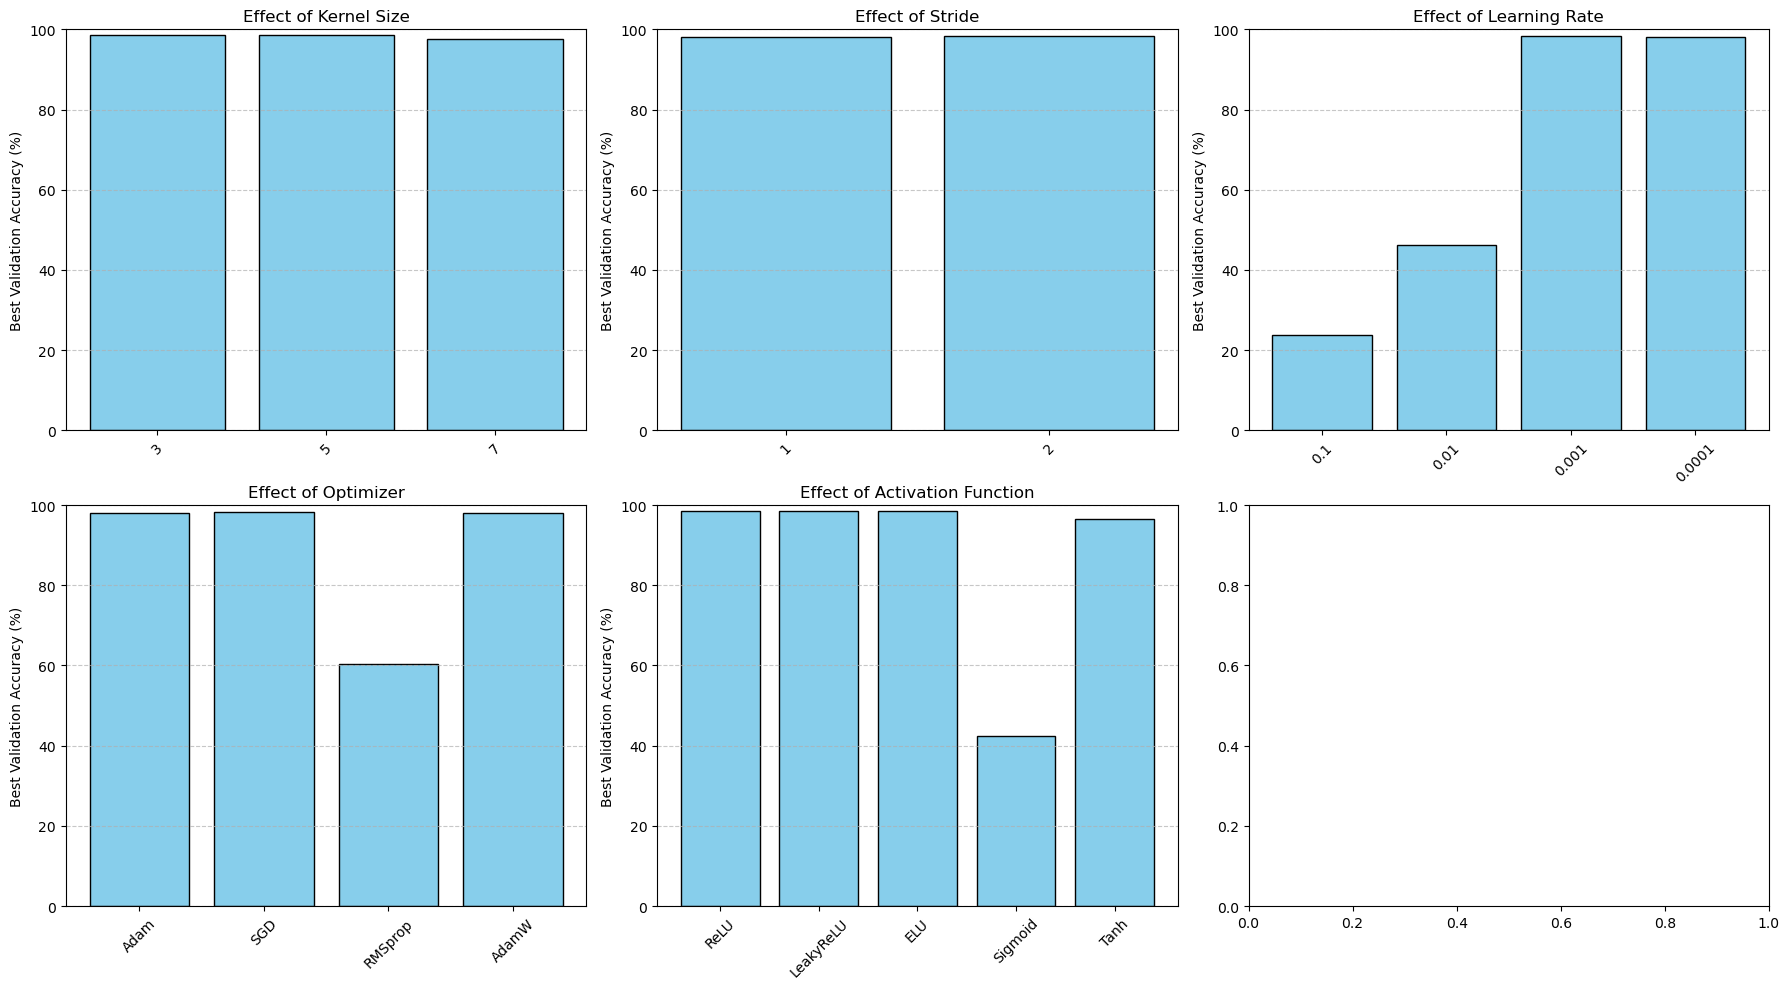

In [7]:
def run_experiment(config_name, param_values, train_loader, val_loader, device, num_classes, epochs=5):
    results = {}

    print(f"--- Running Experiment: {config_name} ---")

    for val in param_values:
        print(f"Testing {config_name} = {val}...")

        # Default Baseline
        k_size = 3
        stride_val = 1 # Stride 1 is safer for small 28x28 images
        lr = 0.001
        opt_type = 'Adam'
        activation_fn = nn.ReLU()

        # Override based on current experiment
        if config_name == 'Kernel Size': k_size = val
        elif config_name == 'Stride': stride_val = val
        elif config_name == 'Learning Rate': lr = val
        elif config_name == 'Optimizer': opt_type = val
        elif config_name == 'Activation Function':
            if val == 'ReLU': activation_fn = nn.ReLU()
            elif val == 'LeakyReLU': activation_fn = nn.LeakyReLU()
            elif val == 'ELU': activation_fn = nn.ELU()
            elif val == 'Sigmoid': activation_fn = nn.Sigmoid()
            elif val == 'Tanh': activation_fn = nn.Tanh()

        # Initialize Model
        model = OrganCNN_Dynamic(num_classes=num_classes, kernelSize=k_size, stride=stride_val, activationFunction=activation_fn).to(device)
        criterion = nn.CrossEntropyLoss()

        # Select Optimizer
        if opt_type == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt_type == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif opt_type == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.9)
        elif opt_type == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr)

        # Short Training Loop
        best_val_acc = 0.0
        for epoch in range(epochs): 
            model.train()
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels.squeeze(1).long())
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.squeeze(1)).sum().item()

            acc = 100 * correct / total
            if acc > best_val_acc: best_val_acc = acc

        results[str(val)] = best_val_acc
        print(f"  -> Best Val Acc: {best_val_acc:.2f}%")

    return results

# --- EXECUTION ---

# 1. Define Search Spaces
experiments = {
    'Kernel Size': [3, 5, 7],
    'Stride': [1, 2], 
    'Learning Rate': [0.1, 0.01, 0.001, 0.0001],
    'Optimizer': ['Adam', 'SGD' , 'RMSprop', 'AdamW'],
    'Activation Function': ['ReLU', 'LeakyReLU', 'ELU', 'Sigmoid', 'Tanh']
}

# 2. Run All Experiments
all_results = {}
n_classes = 11 # OrganAMNIST default

for param_name, values in experiments.items():
    all_results[param_name] = run_experiment(param_name, values, train_loader, val_loader, device, n_classes, epochs=20)

# 3. Plotting
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.ravel()

for i, (param_name, data) in enumerate(all_results.items()):
    axs[i].bar(data.keys(), data.values(), color='skyblue', edgecolor='black')
    axs[i].set_title(f'Effect of {param_name}')
    axs[i].set_ylabel('Best Validation Accuracy (%)')
    axs[i].set_ylim([0, 100])
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Using device: cuda
Best Kernel Size: 3 (Accuracy: 98.51%)
Best Stride: 2 (Accuracy: 98.29%)
Best Learning Rate: 0.001 (Accuracy: 98.27%)
Best Optimizer: SGD (Accuracy: 98.34%)
Best Activation Function: ReLU (Accuracy: 98.58%)

--- Training Final Model with Best Hyperparameters ---
Using: Kernel Size=3, Stride=2, LR=0.001, Optimizer=SGD, Activation=ReLU
Training for 80 epochs...
Epoch 16/80 - Train Loss: 0.1222, Val Acc: 97.55%
Epoch 32/80 - Train Loss: 0.0727, Val Acc: 97.72%
Epoch 48/80 - Train Loss: 0.0247, Val Acc: 97.70%
Epoch 64/80 - Train Loss: 0.0215, Val Acc: 97.81%
Epoch 80/80 - Train Loss: 0.0252, Val Acc: 97.74%

Generating predictions on Test Set...

Test Set Accuracy: 91.72%


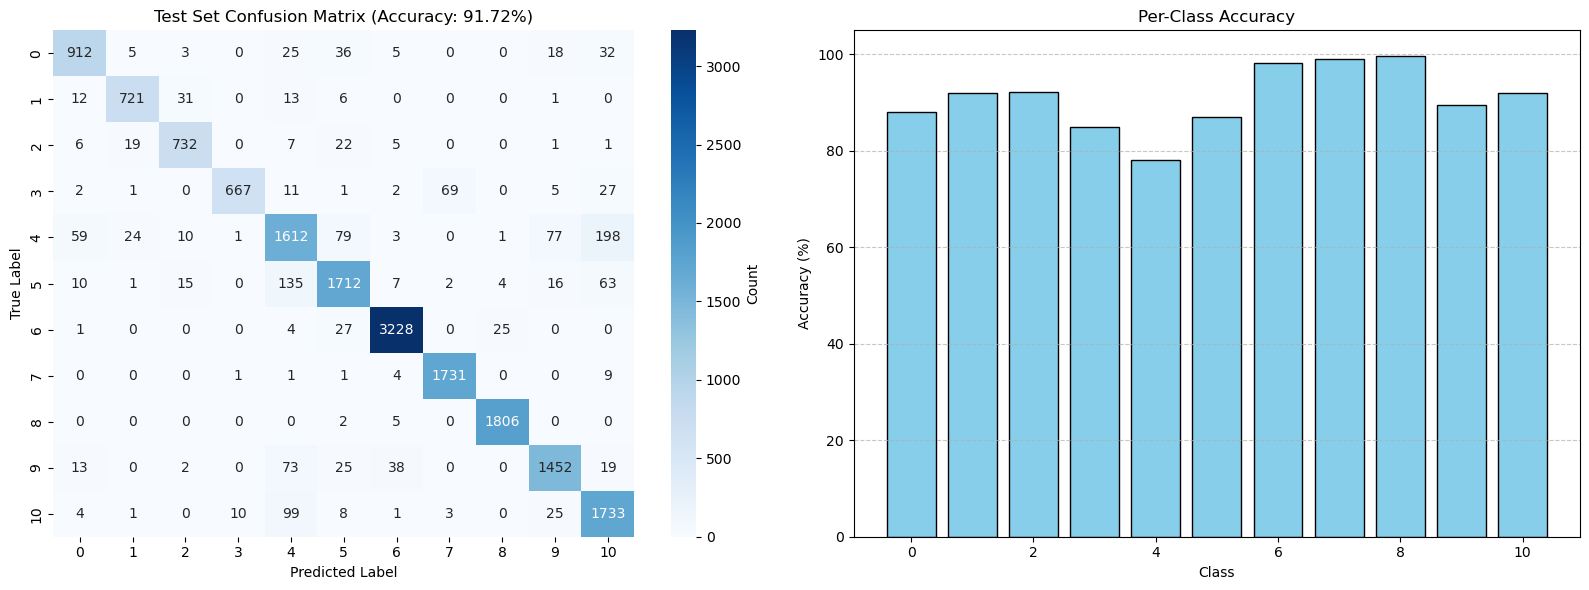


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1036
           1       0.93      0.92      0.93       784
           2       0.92      0.92      0.92       793
           3       0.98      0.85      0.91       785
           4       0.81      0.78      0.80      2064
           5       0.89      0.87      0.88      1965
           6       0.98      0.98      0.98      3285
           7       0.96      0.99      0.97      1747
           8       0.98      1.00      0.99      1813
           9       0.91      0.90      0.90      1622
          10       0.83      0.92      0.87      1884

    accuracy                           0.92     17778
   macro avg       0.92      0.91      0.91     17778
weighted avg       0.92      0.92      0.92     17778

Model saved as 'best_model_final.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from medmnist import OrganAMNIST
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup Data Pipeline (ensure loaders exist)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

if 'test_loader' not in globals():
    testDataset = OrganAMNIST(split="test", download=True, size=28, transform=data_transform)
    test_loader = DataLoader(dataset=testDataset, batch_size=128, shuffle=False)

# Ensure train/val loaders exist (used for quick sweep and final training)
if 'train_loader' not in globals() or 'val_loader' not in globals():
    print("`train_loader` or `val_loader` not found in notebook state — creating from OrganAMNIST datasets.")
    trainDataset = OrganAMNIST(split="train", download=True, size=28, transform=data_transform)
    valDataset = OrganAMNIST(split="val", download=True, size=28, transform=data_transform)
    train_loader = DataLoader(dataset=trainDataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=valDataset, batch_size=64, shuffle=False)

# Ensure device is set
device = globals().get('device', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# Ensure experiments search space exists
if 'experiments' not in globals():
    experiments = {
        'Kernel Size': [3, 5, 7],
        'Stride': [1, 2],
        'Learning Rate': [0.1, 0.01, 0.001, 0.0001],
        'Optimizer': ['Adam', 'SGD', 'RMSprop', 'AdamW'],
        'Activation Function': ['ReLU', 'LeakyReLU', 'ELU', 'Sigmoid', 'Tanh']
    }

# Lightweight run_experiment fallback (only used if original isn't present)
if 'run_experiment' not in globals():
    print("`run_experiment` not found; defining a lightweight fallback for a quick sweep.")
    def run_experiment(config_name, param_values, train_loader, val_loader, device, num_classes, epochs=3):
        results = {}
        for val in param_values:
            # Minimal defaults
            k_size = 3
            stride_val = 1
            lr = 0.001
            opt_type = 'Adam'
            activation_fn = nn.ReLU()

            if config_name == 'Kernel Size': k_size = val
            elif config_name == 'Stride': stride_val = val
            elif config_name == 'Learning Rate': lr = val
            elif config_name == 'Optimizer': opt_type = val
            elif config_name == 'Activation Function':
                if val == 'ReLU': activation_fn = nn.ReLU()
                elif val == 'LeakyReLU': activation_fn = nn.LeakyReLU()
                elif val == 'ELU': activation_fn = nn.ELU()
                elif val == 'Sigmoid': activation_fn = nn.Sigmoid()
                elif val == 'Tanh': activation_fn = nn.Tanh()

            model = OrganCNN_Dynamic(num_classes=num_classes, kernelSize=k_size, stride=stride_val, activationFunction=activation_fn).to(device)
            criterion = nn.CrossEntropyLoss()
            if opt_type == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt_type == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif opt_type == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            elif opt_type == 'AdamW':
                optimizer = optim.AdamW(model.parameters(), lr=lr)
            else:
                optimizer = optim.Adam(model.parameters(), lr=lr)

            best_val_acc = 0.0
            for _ in range(epochs):
                model.train()
                for imgs, labels in train_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(imgs)
                    loss = criterion(outputs, labels.squeeze(1).long())
                    loss.backward()
                    optimizer.step()
                # quick validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for imgs, labels in val_loader:
                        imgs, labels = imgs.to(device), labels.to(device)
                        outputs = model(imgs)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels.squeeze(1)).sum().item()
                acc = 100 * correct / total if total > 0 else 0.0
                if acc > best_val_acc:
                    best_val_acc = acc
            results[str(val)] = best_val_acc
            print(f"  Quick best for {config_name}={val}: {best_val_acc:.2f}%")
        return results


# 3. Select best hyperparameters
best_params = {}
for param_name, data in all_results.items():
    if isinstance(data, dict) and data:
        best_value = max(data, key=data.get)
        best_params[param_name] = best_value
        print(f"Best {param_name}: {best_value} (Accuracy: {data[best_value]:.2f}%)")
    else:
        print(f"No results for {param_name}; skipping.")

# 4. Train final model with chosen hyperparameters
print("\n--- Training Final Model with Best Hyperparameters ---")

k_size = int(best_params.get('Kernel Size', 3))
stride_val = int(best_params.get('Stride', 1))
lr = float(best_params.get('Learning Rate', 0.001))
opt_type = best_params.get('Optimizer', 'Adam')
activation_name = best_params.get('Activation Function', 'ReLU')

activation_map = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
    'GELU': nn.GELU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}
activation_fn = activation_map.get(activation_name, nn.ReLU())

print(f"Using: Kernel Size={k_size}, Stride={stride_val}, LR={lr}, Optimizer={opt_type}, Activation={activation_name}")

best_model = OrganCNN_Dynamic(num_classes=globals().get('n_classes', 11), kernelSize=k_size, stride=stride_val, activationFunction=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()

if opt_type == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=lr)
elif opt_type == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=lr, momentum=0.9)
elif opt_type == 'RMSprop':
    optimizer = optim.RMSprop(best_model.parameters(), lr=lr)
elif opt_type == 'AdamW':
    optimizer = optim.AdamW(best_model.parameters(), lr=lr)
else:
    optimizer = optim.Adam(best_model.parameters(), lr=lr)

# Final training epochs (small by default)
epochs_final = int(globals().get('final_train_epochs', 100))
print(f"Training for {epochs_final} epochs...")
for epoch in range(epochs_final):
    best_model.train()
    train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(imgs)
        loss = criterion(outputs, labels.squeeze(1).long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    best_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = best_model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze(1)).sum().item()
    val_acc = 100 * correct / total if total > 0 else 0.0
    if (epoch + 1) % max(1, epochs_final // 5) == 0 or epoch == epochs_final - 1:
        print(f"Epoch {epoch + 1}/{epochs_final} - Train Loss: {train_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%")

# 5. Test on test set
print("\nGenerating predictions on Test Set...")
best_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1).long()
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 6. Calculate Metrics
test_acc = accuracy_score(y_true, y_pred) * 100
cm = confusion_matrix(y_true, y_pred)
print(f"\nTest Set Accuracy: {test_acc:.2f}%")

# 7. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f'Test Set Confusion Matrix (Accuracy: {test_acc:.2f}%)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

per_class_acc = cm.diagonal() / cm.sum(axis=1)
classes = list(range(cm.shape[0]))
ax2.bar(classes, per_class_acc * 100, color='skyblue', edgecolor='black')
ax2.set_title('Per-Class Accuracy')
ax2.set_ylabel('Accuracy (%)')
ax2.set_xlabel('Class')
ax2.set_ylim([0, 105])
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Save the best model
torch.save(best_model.state_dict(), 'best_model_final.pth')
print("Model saved as 'best_model_final.pth'")
